In [3]:
from DecisionTree import *

def perform_trials(min_feature, max_feature, num_trials):
    
    feature_to_sensitivity = defaultdict(list)
    feature_to_specificity = defaultdict(list)
    feature_to_accuracy = defaultdict(list)
    feature_to_uar = defaultdict(list)
    
    for trial in range(num_trials):
        
        if(trial % 100 == 0):
            print("Trial %d" % (trial + 1))
        
        # read data, perform cleaning, upsampling, etc..
        train, test, data_train, data_test, child_to_index_train, child_to_index_test = get_train_test()
        
        for num_features in range(min_feature, max_feature + 1):

            # get k most important features
            features = select_k_lowest_features(data_train, k=num_features)
            #print(num_features)

            # build decision tree, get root back in tree
            tree = get_decision_tree(data_train, features=features)

            # get graphical representation of decision tree
            tree_g = bfs(tree)

            # validate model on test data
            pred_test = get_predictions(tree, data_test)

            pred_test = child_to_prediction_validate(child_to_index_test, pred_test)

            actual_test = get_child_to_prediction(child_to_index_test, test)

            pred = np.array(list(pred_test.values())).reshape(len(actual_test), 1)

            actual = np.array(list(actual_test.values())).reshape(len(actual_test), 1)

            # get the confusion matrix
            c_matrix = confusion_matrix(pred, actual)

            # get sensitivity, specificity, accuracy, and unweighted average recall
            sensitivity = get_sensitivity(c_matrix)

            specificity = get_specificity(c_matrix)

            accuracy = validate_votes(actual_test, pred_test)

            uar = (sensitivity + specificity) / 2
            
            feature_to_sensitivity[num_features].append(sensitivity)
            feature_to_specificity[num_features].append(specificity)
            feature_to_accuracy[num_features].append(accuracy)
            feature_to_uar[num_features].append(uar)
    
    
    return feature_to_sensitivity, feature_to_specificity, feature_to_accuracy, feature_to_uar

### 1. Decision Trees

In [2]:
NUM_TRIALS = 300
MIN_FEATURE = 3
MAX_FEATURE = 10

feature_to_sensitivity, feature_to_specificity, feature_to_accuracy, feature_to_uar = perform_trials(MIN_FEATURE, MAX_FEATURE, NUM_TRIALS)    

Trial 1
Trial 101
Trial 201


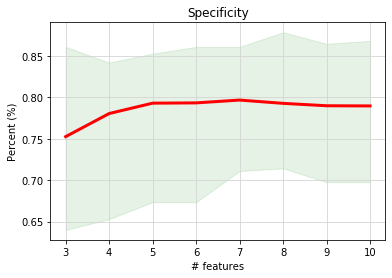

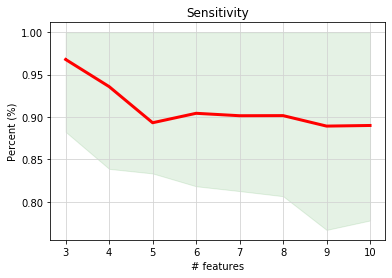

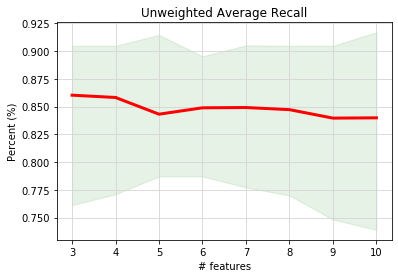

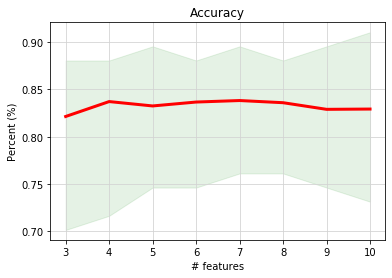

In [3]:
x, y = [], []
ubs, lbs = [], []
for num_feature, values in sorted(feature_to_specificity.items(), key=lambda x:x[0]):
    x.append(num_feature)
    y.append(np.mean(values))
    ubs.append(np.max(values))
    lbs.append(np.min(values))

plt.plot(x, y, marker=',', linewidth=3, color='red')
plt.fill_between(x, ubs, lbs, color='green', alpha=.10)
plt.xlabel("# features")
plt.ylabel("Percent (%)")
plt.title("Specificity")
plt.grid(color='lightgray')
plt.show()

x, y = [], []
ubs, lbs = [], []
for num_feature, values in sorted(feature_to_sensitivity.items(), key=lambda x:x[0]):
    x.append(num_feature)
    y.append(np.mean(values))
    ubs.append(np.max(values))
    lbs.append(np.min(values))

plt.plot(x, y, marker=',', linewidth=3, color='red')
plt.fill_between(x, ubs, lbs, color='green', alpha=.10)
plt.xlabel("# features")
plt.ylabel("Percent (%)")
plt.title("Sensitivity")
plt.grid(color='lightgray')
plt.show()

x, y = [], []
ubs, lbs = [], []
for num_feature, values in sorted(feature_to_uar.items(), key=lambda x:x[0]):
    x.append(num_feature)
    y.append(np.mean(values))
    ubs.append(np.max(values))
    lbs.append(np.min(values))

plt.plot(x, y, marker=',', linewidth=3, color='red')
plt.fill_between(x, ubs, lbs, color='green', alpha=.10)
plt.xlabel("# features")
plt.ylabel("Percent (%)")
plt.title("Unweighted Average Recall")
plt.grid(color='lightgray')
plt.show()

x, y = [], []
ubs, lbs = [], []
for num_feature, values in sorted(feature_to_accuracy.items(), key=lambda x:x[0]):
    x.append(num_feature)
    y.append(np.mean(values))
    ubs.append(np.max(values))
    lbs.append(np.min(values))

plt.plot(x, y, marker=',', linewidth=3, color='red')
plt.fill_between(x, ubs, lbs, color='green', alpha=.10)
plt.xlabel("# features")
plt.ylabel("Percent (%)")
plt.title("Accuracy")
plt.grid(color='lightgray')
plt.show()

### 2. Random Forests

In [4]:
import random
def random_partition(data_partitions):
    
    # get random feature
    features = list(data_partitions.keys())
    random_feature = features[random.randint(0, len(features)-1)]
    
    # get random value for that feature
    values = data_partitions[random_feature]
    random_value = values[random.randint(0, len(values)-1)]
    
    return random_feature, random_value

In [5]:
train, test, data_train, data_test, child_to_index_train, child_to_index_test = get_train_test()

In [6]:
partitions = get_data_partitions(data_train)

In [7]:
random_feature, random_value = random_partition(partitions)

In [8]:
a,b = partition_data(data_train, random_feature, random_value)

In [9]:
def get_decision_tree(data, features=None):
    
    if(is_single_class(data)):
        return classify(data)
    else:
        # get question, and cutoff with lowest overall entropy
        data_partitions = get_data_partitions(data, features)
        split_question, split_value = random_partition(data_partitions)
        
        # no way to split the data with given features.. so return best guess
        if(split_question == None):
            #print("Model performing best guess for leaf node..")
            return classify(data)
            '''
            for x in range(0, data.shape[1]-1):
                if(x in features):
                    print(data[:,x].shape)
                    unique_scores = np.unique(data[:, x])
                    print(x, data[:,x])
                    print(unique_scores)
            '''     
        node = TreeNode(split_question, split_value)
        a, b = partition_data(data, split_question, split_value)
        
        # recurse on left, and right subtrees..
        node.yes = get_decision_tree(a, features)
        node.no = get_decision_tree(b, features)
        
        return node

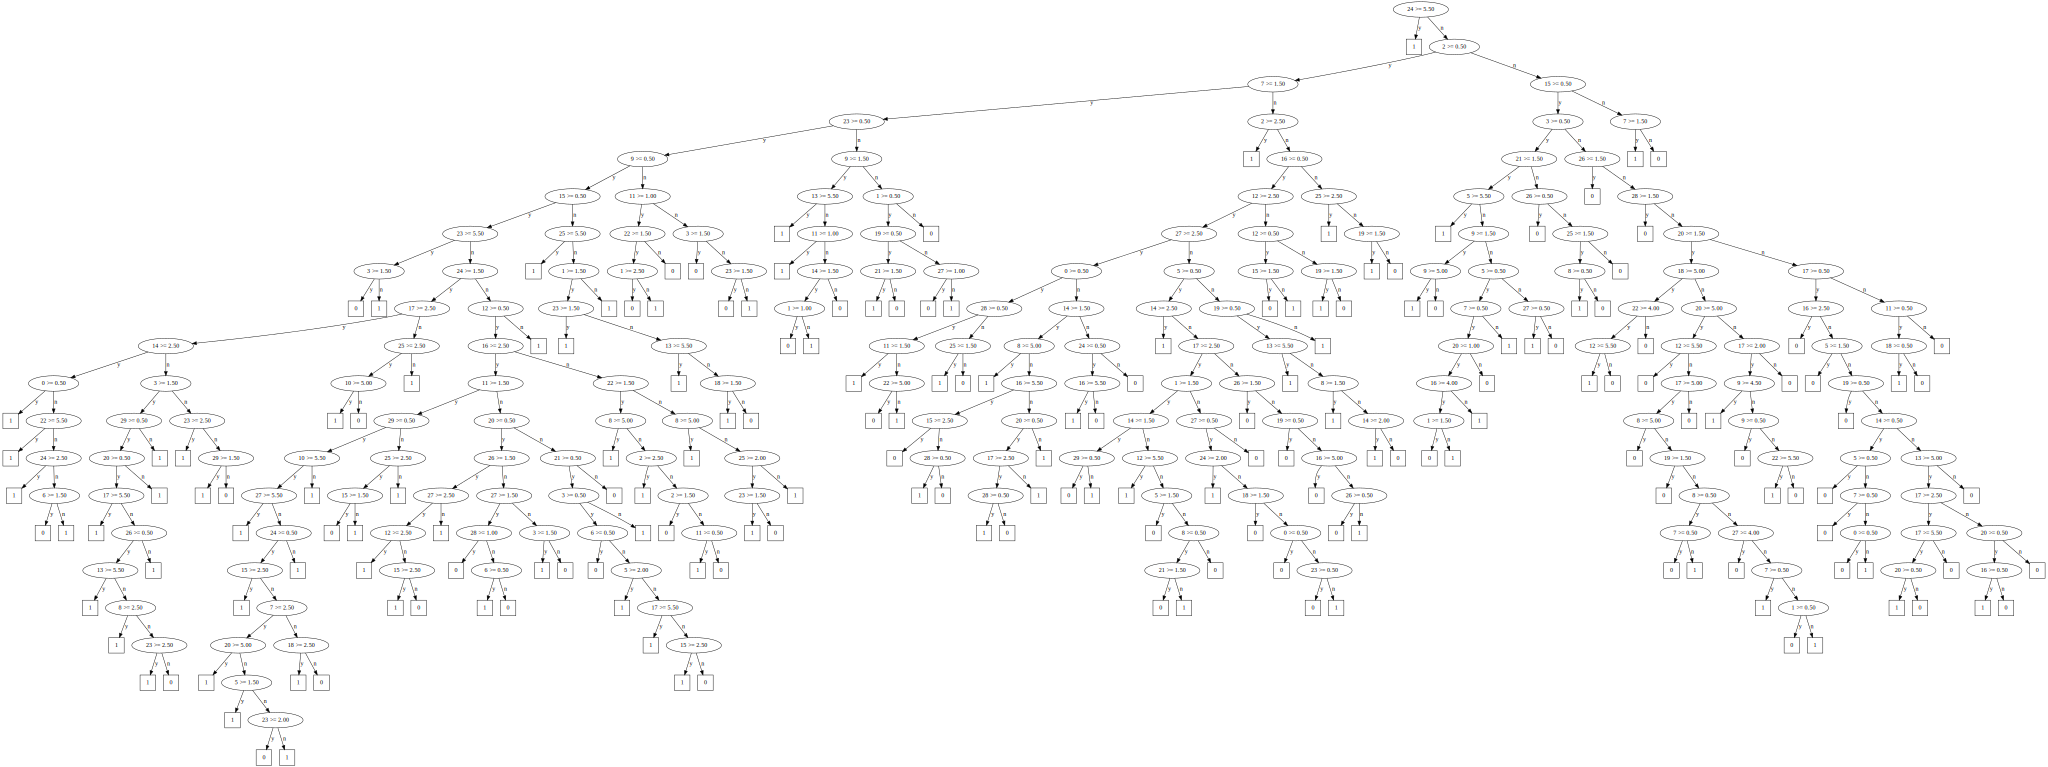

In [10]:
tree_all = get_decision_tree(data_train)
tree_all_g = bfs(tree_all)
tree_all_g

In [429]:
forest = []
NUM_TREES = 100
for x in range(NUM_TREES):
    features = select_k_lowest_features(data_train, k=9)
    tree = get_decision_tree(data_train)
    forest.append(tree)

In [430]:
def get_accuracy(confusion_matrix):
    correct = sum(np.diagonal(confusion_matrix))
    total = sum(sum(confusion_matrix))
    
    return correct / total
    

In [431]:
def get_forest_classification(df, data, forest, child_to_index_test):
    
    actual_test = get_child_to_prediction(child_to_index_test, df)
    actual = np.array(list(actual_test.values())).reshape(len(actual_test), 1)
    
    consensus_predictions = defaultdict(int)
    preds = []
    for tree in forest:
        #print(tree)
        pred_test = get_predictions(tree, data)
        pred_test = child_to_prediction_validate(child_to_index_test, pred_test)
        
        pred = np.array(list(pred_test.values())).reshape(len(actual_test), 1)
        
        # get the confusion matrix
        #c_matrix = confusion_matrix(pred, actual)
        pred = np.squeeze(pred.reshape(1, len(pred)))
        preds.append(pred)
        
    
    for i in range(len(preds)):
        for j in range(len(preds[i])):
            consensus_predictions[j] += preds[i][j]
    
    final_predictions = []
    for patient, votes in sorted(consensus_predictions.items(), key= lambda x: x[0]):
        final_predictions.append(int(votes >= (len(forest) // 2)))
    
    final_predictions = np.array(final_predictions).reshape(len(final_predictions), 1)
    
    return final_predictions, actual
        
        

In [432]:
voted_preds, actual = get_forest_classification(test, data_test, forest, child_to_index_test)
voted_preds.shape, actual.shape

((67, 1), (67, 1))

In [433]:
c_matrix = confusion_matrix(voted_preds, actual)
get_accuracy(c_matrix)

0.8208955223880597

In [440]:
def random_forest_trials(num_trees, num_trials, min_feature, max_feature):
    
    feature_to_sensitivity = defaultdict(list)
    feature_to_specificity = defaultdict(list)
    feature_to_accuracy = defaultdict(list)
    feature_to_uar = defaultdict(list)
    
    for num_features in range(min_feature, max_feature + 1):

        for trial in range(num_trials):
            
            print("Feature %d, Trial %d" % (num_features, trial+1))
            train, test, data_train, data_test, child_to_index_train, child_to_index_test = get_train_test()

            forest = []
            for x in range(num_trees):
                features = select_k_lowest_features(data_train, k=num_features)
                tree = get_decision_tree(data_train)
                forest.append(tree)

            voted_preds, actual = get_forest_classification(test, data_test, forest, child_to_index_test)

            c_matrix = confusion_matrix(voted_preds, actual)

            # get sensitivity, specificity, accuracy, and unweighted average recall
            sensitivity = get_sensitivity(c_matrix)

            specificity = get_specificity(c_matrix)

            accuracy = get_accuracy(c_matrix)

            uar = (sensitivity + specificity) / 2
            
            feature_to_sensitivity[num_features].append(sensitivity)
            feature_to_specificity[num_features].append(specificity)
            feature_to_accuracy[num_features].append(accuracy)
            feature_to_uar[num_features].append(uar)
    
    
    return feature_to_sensitivity, feature_to_specificity, feature_to_accuracy, feature_to_uar
            
            
        
        
        
        
        
        

In [441]:
NUM_TREES = 100
NUM_TRIALS = 10
MIN_FEATURE = 3
MAX_FEATURE = 10

In [442]:
feature_to_sensitivity, feature_to_specificity, feature_to_accuracy, feature_to_uar = random_forest_trials(num_trees=NUM_TREES, num_trials=NUM_TRIALS, min_feature=MIN_FEATURE, max_feature=MAX_FEATURE)

Feature 3, Trial 1
Feature 3, Trial 2
Feature 3, Trial 3
Feature 3, Trial 4
Feature 3, Trial 5
Feature 3, Trial 6
Feature 3, Trial 7
Feature 3, Trial 8
Feature 3, Trial 9
Feature 3, Trial 10
Feature 4, Trial 1
Feature 4, Trial 2
Feature 4, Trial 3
Feature 4, Trial 4
Feature 4, Trial 5
Feature 4, Trial 6
Feature 4, Trial 7
Feature 4, Trial 8
Feature 4, Trial 9
Feature 4, Trial 10
Feature 5, Trial 1
Feature 5, Trial 2
Feature 5, Trial 3
Feature 5, Trial 4
Feature 5, Trial 5
Feature 5, Trial 6
Feature 5, Trial 7
Feature 5, Trial 8
Feature 5, Trial 9
Feature 5, Trial 10
Feature 6, Trial 1
Feature 6, Trial 2
Feature 6, Trial 3
Feature 6, Trial 4
Feature 6, Trial 5
Feature 6, Trial 6
Feature 6, Trial 7
Feature 6, Trial 8
Feature 6, Trial 9
Feature 6, Trial 10
Feature 7, Trial 1
Feature 7, Trial 2
Feature 7, Trial 3
Feature 7, Trial 4
Feature 7, Trial 5
Feature 7, Trial 6
Feature 7, Trial 7
Feature 7, Trial 8
Feature 7, Trial 9
Feature 7, Trial 10
Feature 8, Trial 1
Feature 8, Trial 2
Feature

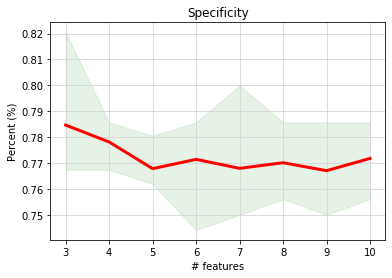

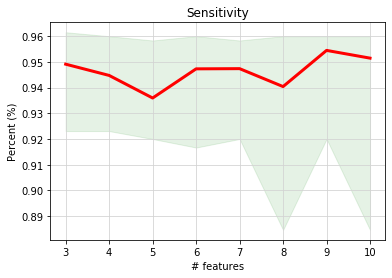

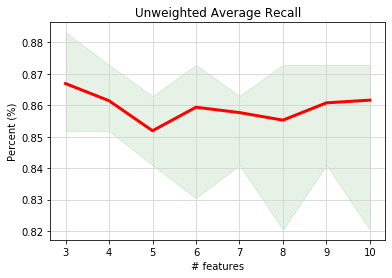

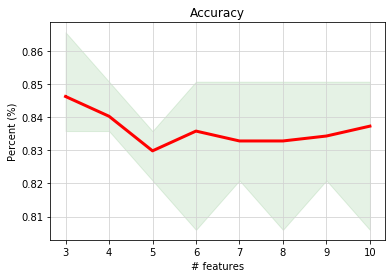

In [443]:
x, y = [], []
ubs, lbs = [], []
for num_feature, values in sorted(feature_to_specificity.items(), key=lambda x:x[0]):
    x.append(num_feature)
    y.append(np.mean(values))
    ubs.append(np.max(values))
    lbs.append(np.min(values))

plt.plot(x, y, marker=',', linewidth=3, color='red')
plt.fill_between(x, ubs, lbs, color='green', alpha=.10)
plt.xlabel("# features")
plt.ylabel("Percent (%)")
plt.title("Specificity")
plt.grid(color='lightgray')
plt.show()

x, y = [], []
ubs, lbs = [], []
for num_feature, values in sorted(feature_to_sensitivity.items(), key=lambda x:x[0]):
    x.append(num_feature)
    y.append(np.mean(values))
    ubs.append(np.max(values))
    lbs.append(np.min(values))

plt.plot(x, y, marker=',', linewidth=3, color='red')
plt.fill_between(x, ubs, lbs, color='green', alpha=.10)
plt.xlabel("# features")
plt.ylabel("Percent (%)")
plt.title("Sensitivity")
plt.grid(color='lightgray')
plt.show()

x, y = [], []
ubs, lbs = [], []
for num_feature, values in sorted(feature_to_uar.items(), key=lambda x:x[0]):
    x.append(num_feature)
    y.append(np.mean(values))
    ubs.append(np.max(values))
    lbs.append(np.min(values))

plt.plot(x, y, marker=',', linewidth=3, color='red')
plt.fill_between(x, ubs, lbs, color='green', alpha=.10)
plt.xlabel("# features")
plt.ylabel("Percent (%)")
plt.title("Unweighted Average Recall")
plt.grid(color='lightgray')
plt.show()

x, y = [], []
ubs, lbs = [], []
for num_feature, values in sorted(feature_to_accuracy.items(), key=lambda x:x[0]):
    x.append(num_feature)
    y.append(np.mean(values))
    ubs.append(np.max(values))
    lbs.append(np.min(values))

plt.plot(x, y, marker=',', linewidth=3, color='red')
plt.fill_between(x, ubs, lbs, color='green', alpha=.10)
plt.xlabel("# features")
plt.ylabel("Percent (%)")
plt.title("Accuracy")
plt.grid(color='lightgray')
plt.show()